# Importamos las librerías necesarias

In [93]:
import pandas as pd
import requests

# Obtención de datos

En primer lugar, debemos obtener los datos que emplearemos para el entrenamiento de la red neuronal. Para ello, haremos uso del API expuesta por el microservicio desarrollado en el proyecto.

In [94]:
BASE_PATH = 'http://sofascore-data-crawler.azurewebsites.net/data-miner'

### Obtención de datos de partidos ya disputados

In [95]:
from datetime import date

finished_events = True

today = date.today()
date_formatted = today.strftime("%d_%m_%Y")

# Generamos el endpoint del microservicio
req = requests.get(BASE_PATH + '/events?finished=' + str(finished_events).lower())

# Generamos un dataframe en base a la respuesta obtenida por el API
df_events = pd.DataFrame.from_dict(req.json())
df_events.head()

df_events.to_csv('/content/events_data_' + date_formatted + '.csv', encoding="utf-8")

## Preparación de los datos

###Eliminamos columnas innecesarias

In [96]:
df_events = df_events.drop(columns = ['id', 'status', 'groundType'], axis=1)
df_events.head()

,slug,date,firstToServe,winner,homePlayer,awayPlayer,homeScore,awayScore,doubles
0,fucsovics-fognini,2021-06-03,fucsovics-marton,fognini-fabio,"{'id': 1, 'name': 'Fognini F.', 'shortName': '...","{'id': 2, 'name': 'Fucsovics M.', 'shortName':...","{'current': 3, 'period1': 7, 'period2': 6, 'pe...","{'current': 0, 'period1': 6, 'period2': 1, 'pe...",False
1,krajinovic-isner,2021-06-03,krajinovic-filip,isner-john,"{'id': 4, 'name': 'Krajinović F.', 'shortName'...","{'id': 5, 'name': 'Isner J.', 'shortName': 'Is...","{'current': 0, 'period1': 6, 'period2': 1, 'pe...","{'current': 3, 'period1': 7, 'period2': 6, 'pe...",False
2,opelka-munar,2021-06-03,opelka-reilly,opelka-reilly,"{'id': 7, 'name': 'Opelka R.', 'shortName': 'O...","{'id': 8, 'name': 'Munar J.', 'shortName': 'Mu...","{'current': 3, 'period1': 6, 'period2': 6, 'pe...","{'current': 1, 'period1': 3, 'period2': 2, 'pe...",False
3,martinez-tsitsipas,2021-06-03,tsitsipas-stefanos,tsitsipas-stefanos,"{'id': 10, 'name': 'Tsitsipas S.', 'shortName'...","{'id': 11, 'name': 'Martínez P.', 'shortName':...","{'current': 3, 'period1': 6, 'period2': 6, 'pe...","{'current': 0, 'period1': 3, 'period2': 4, 'pe...",False
4,giron-pella,2021-06-03,pella-guido,giron-marcos,"{'id': 13, 'name': 'Giron M.', 'shortName': 'G...","{'id': 14, 'name': 'Pella G.', 'shortName': 'P...","{'current': 3, 'period1': 7, 'period2': 6, 'pe...","{'current': 1, 'period1': 6, 'period2': 1, 'pe...",False


Vemos que debido a la estructura del JSON que devuelve el API, tenemos que  realizar unas operaciones hasta tener el dataframe final. Las columnas afectadas serán:
* homePlayer
* awayPlayer
* homeScore
* awayScore

In [97]:
# Generamos el dataframe con los datos del jugador en casa
drop_player_columns = ['id', 'sport', 'name', 'shortName', 'fullName', 'nameCode', 'residence', 'birthplace', 'country', 'gender']

df_homeplayer = pd.DataFrame.from_records(df_events['homePlayer'])
df_homeplayer = df_homeplayer.drop(columns = drop_player_columns, axis=1)
df_homeplayer.columns = [str(col) + '_homePlayer' for col in df_homeplayer.columns]

# Generamos el dataframe con los datos del jugador en casa
df_awayplayer = pd.DataFrame.from_records(df_events['awayPlayer'])
df_awayplayer = df_awayplayer.drop(columns = drop_player_columns, axis=1)
df_awayplayer.columns = [str(col) + '_awayPlayer' for col in df_awayplayer.columns]

# Generamos el dataframe con la puntuación obtenida por set por el jugador en casa
if(finished_events):
  df_homescore = pd.DataFrame.from_records(df_events['homeScore'])
  df_homescore.columns = [str(col) + '_home' for col in df_homescore.columns]

# Generamos el dataframe con la puntuación obtenida por set por el jugador fuera
if(finished_events):
  df_awayscore = pd.DataFrame.from_records(df_events['awayScore'])
  df_awayscore.columns = [str(col) + '_away' for col in df_awayscore.columns]

In [98]:
df_events = df_events.drop(columns = ['homePlayer', 'awayPlayer', 'homeScore', 'awayScore'], axis=1)

if (finished_events):
  df_events = pd.concat([df_events, df_homeplayer, df_awayplayer, df_homescore, df_awayscore], axis=1)
else:
 df_events = pd.concat([df_events, df_homeplayer, df_awayplayer], axis=1)

In [99]:
df_events.head()

,slug,date,firstToServe,winner,doubles,slug_homePlayer,height_homePlayer,weight_homePlayer,plays_homePlayer,turnedPro_homePlayer,prizeCurrent_homePlayer,prizeTotal_homePlayer,birthDateTimestamp_homePlayer,ranking_homePlayer,previousRanking_homePlayer,bestRanking_homePlayer,tournamentsPlayed_homePlayer,points_homePlayer,national_homePlayer,slug_awayPlayer,height_awayPlayer,weight_awayPlayer,plays_awayPlayer,turnedPro_awayPlayer,prizeCurrent_awayPlayer,prizeTotal_awayPlayer,birthDateTimestamp_awayPlayer,ranking_awayPlayer,previousRanking_awayPlayer,bestRanking_awayPlayer,tournamentsPlayed_awayPlayer,points_awayPlayer,national_awayPlayer,current_home,period1_home,period2_home,period3_home,period4_home,period5_home,period6_home,period1TieBreak_home,period2TieBreak_home,period3TieBreak_home,period4TieBreak_home,period5TieBreak_home,period6TieBreak_home,current_away,period1_away,period2_away,period3_away,period4_away,period5_away,period6_away,period1TieBreak_away,period2TieBreak_away,period3TieBreak_away,period4TieBreak_away,period5TieBreak_away,period6TieBreak_away
0,fucsovics-fognini,2021-06-03,fucsovics-marton,fognini-fabio,False,fognini-fabio,1.78,79,right-handed,2004,739018.0,13304618,548812800,31,31.0,9.0,31.0,1868.0,False,fucsovics-marton,1.88,82,right-handed,2010,458998.0,3393732.0,697507200.0,48.0,49.0,31.0,32.0,1344.0,False,3,7,6,6.0,NaN,NaN,None,8.0,NaN,NaN,NaN,NaN,None,0,6,1,2.0,NaN,NaN,None,6.0,NaN,NaN,NaN,NaN,None
1,krajinovic-isner,2021-06-03,krajinovic-filip,isner-john,False,krajinovic-filip,1.85,75,right-handed,2008,385933.0,3601518,699148800,44,44.0,26.0,30.0,1514.0,False,isner-john,2.08,108,right-handed,2007,232452.0,16344457.0,483321600.0,33.0,33.0,8.0,22.0,1775.0,False,0,6,1,6.0,NaN,NaN,None,6.0,NaN,5.0,NaN,NaN,None,3,7,6,7.0,NaN,NaN,None,8.0,NaN,7.0,NaN,NaN,None
2,opelka-munar,2021-06-03,opelka-reilly,opelka-reilly,False,opelka-reilly,2.11,102,right-handed,2015,373462.0,2146707,872726400,32,32.0,31.0,30.0,1806.0,False,munar-jaume,1.83,76,right-handed,2014,277452.0,1670088.0,862790400.0,66.0,69.0,52.0,47.0,1022.0,False,3,6,6,3.0,7.0,NaN,None,NaN,NaN,NaN,NaN,NaN,None,1,3,2,6.0,5.0,NaN,None,NaN,NaN,NaN,NaN,NaN,None
3,martinez-tsitsipas,2021-06-03,tsitsipas-stefanos,tsitsipas-stefanos,False,tsitsipas-stefanos,1.93,85,right-handed,2016,2109053.0,12596725,902880000,4,4.0,4.0,30.0,8150.0,False,martinez-pedro,1.85,76,right-handed,2016,393823.0,1164050.0,862012800.0,95.0,107.0,82.0,44.0,811.0,False,3,6,6,6.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0,3,4,3.0,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
4,giron-pella,2021-06-03,pella-guido,giron-marcos,False,giron-marcos,1.8,77,right-handed,2014,289749.0,1060038,743472000,66,65.0,65.0,39.0,1037.0,False,pella-guido,1.83,79,left-handed,2007,275256.0,4520963.0,642902400.0,59.0,59.0,20.0,30.0,1114.0,False,3,7,6,6.0,6.0,NaN,None,7.0,NaN,3.0,NaN,NaN,None,1,6,1,7.0,4.0,NaN,None,2.0,NaN,7.0,NaN,NaN,None


### Convertimos variables categóricas en numéricas

Puesto que vamos a predecir victoria o derrota en función de parámetros como resultados obtenidos en partidos pasados y otros parámetros característicos de los jugadores como altura, peso, cotización... necesitamos trabajar con variables numéricas.

Sin embargo, observamos que hay variables categóricas que facilmente se pueden convertir a numéricas

In [100]:
# Mapping table:
# right-handed --> 1
# left-handed --> 0
# ground_type --> Clay:1, Grass:0
# winner --> home:1, away:0

# Set way of play as a numeric variable
df_events['plays_homePlayer'] = df_events['plays_homePlayer'].replace(['right-handed','left-handed'],[1,0])
df_events['plays_awayPlayer'] = df_events['plays_awayPlayer'].replace(['right-handed','left-handed'],[1,0])

# Set groundType as a numeric variable
#df_events['groundType'] = df_events['groundType'].replace(['Clay', 'Grass'],[1, 0])

# Set winner as a numeric variable
if(finished_events):
  for index, row in df_events.iterrows():
    df_events.at[index,'winner'] = 1 if row['winner'] == row['slug_homePlayer'] else 0
    if row['current_home'] == 3 or row['current_away'] == 3:
      df_events.drop(index, inplace=True)

In [101]:
df_events.head()

,slug,date,firstToServe,winner,doubles,slug_homePlayer,height_homePlayer,weight_homePlayer,plays_homePlayer,turnedPro_homePlayer,prizeCurrent_homePlayer,prizeTotal_homePlayer,birthDateTimestamp_homePlayer,ranking_homePlayer,previousRanking_homePlayer,bestRanking_homePlayer,tournamentsPlayed_homePlayer,points_homePlayer,national_homePlayer,slug_awayPlayer,height_awayPlayer,weight_awayPlayer,plays_awayPlayer,turnedPro_awayPlayer,prizeCurrent_awayPlayer,prizeTotal_awayPlayer,birthDateTimestamp_awayPlayer,ranking_awayPlayer,previousRanking_awayPlayer,bestRanking_awayPlayer,tournamentsPlayed_awayPlayer,points_awayPlayer,national_awayPlayer,current_home,period1_home,period2_home,period3_home,period4_home,period5_home,period6_home,period1TieBreak_home,period2TieBreak_home,period3TieBreak_home,period4TieBreak_home,period5TieBreak_home,period6TieBreak_home,current_away,period1_away,period2_away,period3_away,period4_away,period5_away,period6_away,period1TieBreak_away,period2TieBreak_away,period3TieBreak_away,period4TieBreak_away,period5TieBreak_away,period6TieBreak_away
41,jung-broady,2021-05-25,broady-liam,0,False,jung-jason,1.8,69,1.0,2011,57798.0,748339,613872000,163,160.0,114.0,42.0,441.0,False,broady-liam,1.83,78,0.0,2014,94369.0,689830.0,757641600.0,143.0,144.0,137.0,44.0,509.0,False,0,4,2,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
150,djokovic-molcan,2021-05-30,molcan-alex,1,False,djokovic-novak,1.88,77,1.0,2003,3446363.0,124841675,548640000,1,1.0,1.0,20.0,12113.0,False,molcan-alex,1.78,73,0.0,None,101786.0,164704.0,880934400.0,160.0,158.0,158.0,48.0,451.0,False,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0,4,3,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
166,ymer-menezes,2021-05-24,ymer-elias,1,False,menezes-joao,1.85,81,1.0,None,66193.0,216170,850780800,211,206.0,172.0,50.0,333.0,False,ymer-elias,1.8,79,1.0,2014,101941.0,925874.0,829094400.0,169.0,167.0,105.0,38.0,428.0,False,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0,3,4,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
187,cecchinato-korda,2021-05-30,korda-sebastian,1,False,korda-sebastian,1.96,75,1.0,None,284133.0,666215,962755200,50,50.0,50.0,39.0,1272.0,False,cecchinato-marco,1.85,78,1.0,2010,362638.0,3386387.0,717811200.0,82.0,86.0,16.0,44.0,888.0,False,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0,2,4,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
188,brooksby-furness,2021-05-29,furness-evan,0,False,furness-evan,1.7,66,1.0,None,14166.0,78949,902966400,327,329.0,327.0,47.0,151.0,False,brooksby-jenson,1.93,64,1.0,140,90093.0,240996.0,972518400.0,152.0,147.0,147.0,18.0,487.0,False,1,7,6,4.0,NaN,NaN,None,7.0,2.0,NaN,NaN,NaN,None,2,6,7,6.0,NaN,NaN,None,5.0,7.0,NaN,NaN,NaN,None


Finalmente, eliminamos el resto de columnas que no vamos a necesitar para el entrenamiento

In [102]:
df_events = df_events.drop(columns = ['slug', 'slug_homePlayer', 'slug_awayPlayer', 'date', 'firstToServe', 'doubles', 'national_homePlayer', 'national_awayPlayer'], axis=1)
df_events.head()

,winner,height_homePlayer,weight_homePlayer,plays_homePlayer,turnedPro_homePlayer,prizeCurrent_homePlayer,prizeTotal_homePlayer,birthDateTimestamp_homePlayer,ranking_homePlayer,previousRanking_homePlayer,bestRanking_homePlayer,tournamentsPlayed_homePlayer,points_homePlayer,height_awayPlayer,weight_awayPlayer,plays_awayPlayer,turnedPro_awayPlayer,prizeCurrent_awayPlayer,prizeTotal_awayPlayer,birthDateTimestamp_awayPlayer,ranking_awayPlayer,previousRanking_awayPlayer,bestRanking_awayPlayer,tournamentsPlayed_awayPlayer,points_awayPlayer,current_home,period1_home,period2_home,period3_home,period4_home,period5_home,period6_home,period1TieBreak_home,period2TieBreak_home,period3TieBreak_home,period4TieBreak_home,period5TieBreak_home,period6TieBreak_home,current_away,period1_away,period2_away,period3_away,period4_away,period5_away,period6_away,period1TieBreak_away,period2TieBreak_away,period3TieBreak_away,period4TieBreak_away,period5TieBreak_away,period6TieBreak_away
41,0,1.8,69,1.0,2011,57798.0,748339,613872000,163,160.0,114.0,42.0,441.0,1.83,78,0.0,2014,94369.0,689830.0,757641600.0,143.0,144.0,137.0,44.0,509.0,0,4,2,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
150,1,1.88,77,1.0,2003,3446363.0,124841675,548640000,1,1.0,1.0,20.0,12113.0,1.78,73,0.0,None,101786.0,164704.0,880934400.0,160.0,158.0,158.0,48.0,451.0,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0,4,3,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
166,1,1.85,81,1.0,None,66193.0,216170,850780800,211,206.0,172.0,50.0,333.0,1.8,79,1.0,2014,101941.0,925874.0,829094400.0,169.0,167.0,105.0,38.0,428.0,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0,3,4,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
187,1,1.96,75,1.0,None,284133.0,666215,962755200,50,50.0,50.0,39.0,1272.0,1.85,78,1.0,2010,362638.0,3386387.0,717811200.0,82.0,86.0,16.0,44.0,888.0,2,6,6,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None,0,2,4,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,None
188,0,1.7,66,1.0,None,14166.0,78949,902966400,327,329.0,327.0,47.0,151.0,1.93,64,1.0,140,90093.0,240996.0,972518400.0,152.0,147.0,147.0,18.0,487.0,1,7,6,4.0,NaN,NaN,None,7.0,2.0,NaN,NaN,NaN,None,2,6,7,6.0,NaN,NaN,None,5.0,7.0,NaN,NaN,NaN,None


Llegados a este punto, todo el dataframe contiene únicamente variables numéricas. Tenemos que revisar ahora si contiene valores nulos o no informados y qué hacer.

A priori, se realizará la siguiente operación sobre las columnas que contengan valores nulos:

* weight --> Se sustituirá por la media
* height --> Se sustituirá por la media
* turnedPro --> Se sustituirá por la media
* prizeTotal --> Se sustituirá por la media
* ranking --> Se sustituirá por la media


In [103]:
df_events.describe() 

,plays_homePlayer,prizeCurrent_homePlayer,prizeTotal_homePlayer,birthDateTimestamp_homePlayer,ranking_homePlayer,previousRanking_homePlayer,bestRanking_homePlayer,tournamentsPlayed_homePlayer,points_homePlayer,plays_awayPlayer,prizeCurrent_awayPlayer,prizeTotal_awayPlayer,birthDateTimestamp_awayPlayer,ranking_awayPlayer,previousRanking_awayPlayer,bestRanking_awayPlayer,tournamentsPlayed_awayPlayer,points_awayPlayer,current_home,period1_home,period2_home,period3_home,period4_home,period5_home,period1TieBreak_home,period2TieBreak_home,period3TieBreak_home,period4TieBreak_home,period5TieBreak_home,current_away,period1_away,period2_away,period3_away,period4_away,period5_away,period1TieBreak_away,period2TieBreak_away,period3TieBreak_away,period4TieBreak_away,period5TieBreak_away
count,1112.000000,1.116000e+03,1.119000e+03,1.119000e+03,1119.000000,1116.000000,1116.000000,1116.000000,1116.000000,1112.000000,1.116000e+03,1.116000e+03,1.116000e+03,1115.000000,1116.000000,1116.000000,1116.000000,1116.000000,1119.000000,1119.000000,1119.000000,426.000000,0.0,0.0,174.000000,182.000000,59.000000,0.0,0.0,1119.000000,1119.000000,1119.000000,426.000000,0.0,0.0,174.000000,182.000000,59.000000,0.0,0.0
mean,0.847122,3.518559e+05,7.192279e+06,7.437753e+08,129.528150,126.663978,84.944444,37.294803,1463.346774,0.812050,2.939046e+05,4.431308e+06,7.664656e+08,134.289686,135.642473,95.399642,37.978495,1293.023297,1.215371,4.941019,4.899017,4.929577,NaN,NaN,6.160920,5.829670,6.728814,NaN,NaN,1.165326,4.822163,4.887399,4.812207,NaN,NaN,6.235632,5.747253,6.237288,NaN,NaN
std,0.360031,5.338687e+05,2.073095e+07,1.480342e+08,150.581689,136.854146,122.932766,9.442486,2217.510230,0.390848,3.757081e+05,1.222138e+07,1.471155e+08,133.915497,137.596565,129.026558,9.396950,1824.428821,0.877617,1.775430,1.826458,1.831674,NaN,NaN,2.086973,2.302677,6.822454,NaN,NaN,0.881338,1.865708,1.819643,1.909097,NaN,NaN,2.133329,2.378975,4.868403,NaN,NaN
min,0.000000,2.170000e+02,4.950000e+02,2.890080e+08,1.000000,1.000000,1.000000,6.000000,6.000000,0.000000,5.420000e+02,1.784000e+03,2.890080e+08,2.000000,2.000000,1.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,1.000000,0.000000,2.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,1.000000,8.972700e+04,5.912500e+05,6.304608e+08,49.500000,48.500000,22.000000,31.000000,423.000000,1.000000,6.610300e+04,4.196848e+05,6.550848e+08,49.000000,49.000000,24.000000,32.000000,405.000000,0.000000,4.000000,4.000000,4.000000,NaN,NaN,5.000000,4.000000,4.000000,NaN,NaN,0.000000,3.000000,3.000000,4.000000,NaN,NaN,5.000000,4.000000,4.000000,NaN,NaN
50%,1.000000,2.390380e+05,1.468338e+06,7.576416e+08,97.000000,95.500000,53.000000,38.000000,802.000000,1.000000,1.892220e+05,1.361718e+06,8.001504e+08,113.000000,113.000000,67.000000,39.000000,704.500000,2.000000,6.000000,6.000000,6.000000,NaN,NaN,7.000000,7.000000,6.000000,NaN,NaN,1.000000,6.000000,6.000000,6.000000,NaN,NaN,7.000000,7.000000,7.000000,NaN,NaN
75%,1.000000,3.828832e+05,4.457147e+06,8.547552e+08,172.000000,166.250000,111.000000,44.000000,1309.000000,1.000000,3.755652e+05,3.866143e+06,8.773056e+08,180.000000,176.000000,124.000000,44.000000,1309.000000,2.000000,6.000000,6.000000,6.000000,NaN,NaN,7.000000,7.000000,7.000000,NaN,NaN,2.000000,6.000000,6.000000,6.000000,NaN,NaN,7.000000,7.000000,7.000000,NaN,NaN
max,1.000000,3.446363e+06,1.248417e+08,1.086998e+09,1496.000000,1207.000000,1207.000000,59.000000,12113.000000,1.000000,2.109053e+06,1.085256e+08,1.058486e+09,1194.000000,1194.000000,1183.000000,59.000000,10280.000000,2.000000,7.000000,7.000000,8.000000,NaN,NaN,11.000000,16.000000,50.000000,NaN,NaN,2.000000,7.000000,7.000000,10.000000,NaN,NaN,12.000000,18.000000,40.000000,NaN,NaN


In [104]:
# plays
mode_plays_home = pd.to_numeric(df_events['plays_homePlayer'], errors='coerce').mode()
mode_plays_away = pd.to_numeric(df_events['plays_awayPlayer'], errors='coerce').mode()
df_events['plays_homePlayer'] = df_events['plays_homePlayer'].fillna(1)
df_events['plays_awayPlayer'] = df_events['plays_awayPlayer'].fillna(1)

# TurnedPro
meanTurnedPro_home = pd.to_numeric(df_events['turnedPro_homePlayer'], errors='coerce').mean()
meanTurnedPro_away = pd.to_numeric(df_events['turnedPro_awayPlayer'], errors='coerce').mean()
df_events['turnedPro_homePlayer'] = df_events['turnedPro_homePlayer'].fillna(meanTurnedPro_home)
df_events['turnedPro_awayPlayer'] = df_events['turnedPro_awayPlayer'].fillna(meanTurnedPro_away)

# prizeTotal
meanPrizeTotal_home = pd.to_numeric(df_events['prizeTotal_homePlayer'], errors='coerce').mean()
meanPrizeTotal_away = pd.to_numeric(df_events['prizeTotal_awayPlayer'], errors='coerce').mean()
df_events['prizeTotal_homePlayer'] = df_events['prizeTotal_homePlayer'].fillna(meanPrizeTotal_home)
df_events['prizeTotal_awayPlayer'] = df_events['prizeTotal_awayPlayer'].fillna(meanPrizeTotal_away)

# prizeCurrent
meanPrizeCurrent_home = pd.to_numeric(df_events['prizeCurrent_homePlayer'], errors='coerce').mean()
meanPrizeCurrent_away = pd.to_numeric(df_events['prizeCurrent_awayPlayer'], errors='coerce').mean()
df_events['prizeCurrent_homePlayer'] = df_events['prizeCurrent_homePlayer'].fillna(meanPrizeCurrent_home)
df_events['prizeCurrent_awayPlayer'] = df_events['prizeCurrent_awayPlayer'].fillna(meanPrizeCurrent_away)

# prizeCurrent
meanPoints_home = pd.to_numeric(df_events['points_homePlayer'], errors='coerce').mean()
meanPoints_away = pd.to_numeric(df_events['points_awayPlayer'], errors='coerce').mean()
df_events['points_homePlayer'] = df_events['points_homePlayer'].fillna(meanPoints_home)
df_events['points_awayPlayer'] = df_events['points_awayPlayer'].fillna(meanPoints_away)

# weigth
weight_home = pd.to_numeric(df_events['weight_homePlayer'], errors='coerce').mean()
weight_away = pd.to_numeric(df_events['weight_awayPlayer'], errors='coerce').mean()
df_events['weight_homePlayer'] = df_events['weight_homePlayer'].fillna(weight_home)
df_events['weight_awayPlayer'] = df_events['weight_awayPlayer'].fillna(weight_away)

# heigth
height_home = pd.to_numeric(df_events['height_homePlayer'], errors='coerce').mean()
height_away = pd.to_numeric(df_events['height_awayPlayer'], errors='coerce').mean()
df_events['height_homePlayer'] = df_events['height_homePlayer'].fillna(height_home)
df_events['height_awayPlayer'] = df_events['height_awayPlayer'].fillna(height_away)

# ranking
ranking_home = pd.to_numeric(df_events['ranking_homePlayer'], errors='coerce').mean()
ranking_away = pd.to_numeric(df_events['ranking_awayPlayer'], errors='coerce').mean()
df_events['ranking_homePlayer'] = df_events['ranking_homePlayer'].fillna(ranking_home)
df_events['ranking_awayPlayer'] = df_events['ranking_awayPlayer'].fillna(ranking_away)

# bestRanking
best_ranking_home = pd.to_numeric(df_events['bestRanking_homePlayer'], errors='coerce').mean()
best_ranking_away = pd.to_numeric(df_events['bestRanking_awayPlayer'], errors='coerce').mean()
df_events['bestRanking_homePlayer'] = df_events['bestRanking_homePlayer'].fillna(best_ranking_home)
df_events['bestRanking_awayPlayer'] = df_events['bestRanking_awayPlayer'].fillna(best_ranking_away)

# previousRanking
previous_ranking_home = pd.to_numeric(df_events['previousRanking_homePlayer'], errors='coerce').mean()
previous_ranking_away = pd.to_numeric(df_events['previousRanking_awayPlayer'], errors='coerce').mean()
df_events['previousRanking_homePlayer'] = df_events['previousRanking_homePlayer'].fillna(best_ranking_home)
df_events['previousRanking_awayPlayer'] = df_events['previousRanking_awayPlayer'].fillna(best_ranking_away)

# tournamentsPlayed
mean_tournamentsPlayed_home = pd.to_numeric(df_events['tournamentsPlayed_homePlayer'], errors='coerce').mean()
mean_tournamentsPlayed_away = pd.to_numeric(df_events['tournamentsPlayed_awayPlayer'], errors='coerce').mean()
df_events['tournamentsPlayed_homePlayer'] = df_events['tournamentsPlayed_homePlayer'].fillna(mean_tournamentsPlayed_home)
df_events['tournamentsPlayed_awayPlayer'] = df_events['tournamentsPlayed_awayPlayer'].fillna(mean_tournamentsPlayed_away)

# birthDateTimestamp
mean_birthDateTimestamp_home = pd.to_numeric(df_events['birthDateTimestamp_homePlayer'], errors='coerce').mean()
mean_birthDateTimestamp_away = pd.to_numeric(df_events['birthDateTimestamp_awayPlayer'], errors='coerce').mean()
df_events['birthDateTimestamp_homePlayer'] = df_events['birthDateTimestamp_homePlayer'].fillna(mean_birthDateTimestamp_home)
df_events['birthDateTimestamp_awayPlayer'] = df_events['birthDateTimestamp_awayPlayer'].fillna(mean_birthDateTimestamp_away)

# sets information
if(finished_events):
  df_events['period1_home'] = df_events['period1_home'].fillna(0)
  df_events['period2_home'] = df_events['period2_home'].fillna(0)
  df_events['period3_home'] = df_events['period3_home'].fillna(0)
  df_events['period4_home'] = df_events['period4_home'].fillna(0)
  df_events['period5_home'] = df_events['period5_home'].fillna(0)
  df_events['period6_home'] = df_events['period6_home'].fillna(0)
  df_events['period1TieBreak_home'] = df_events['period1TieBreak_home'].fillna(0)
  df_events['period2TieBreak_home'] = df_events['period2TieBreak_home'].fillna(0)
  df_events['period3TieBreak_home'] = df_events['period3TieBreak_home'].fillna(0)
  df_events['period4TieBreak_home'] = df_events['period4TieBreak_home'].fillna(0)
  df_events['period5TieBreak_home'] = df_events['period5TieBreak_home'].fillna(0)
  df_events['period6TieBreak_home'] = df_events['period6TieBreak_home'].fillna(0)

  df_events['period1_away'] = df_events['period1_away'].fillna(0)
  df_events['period2_away'] = df_events['period2_away'].fillna(0)
  df_events['period3_away'] = df_events['period3_away'].fillna(0)
  df_events['period4_away'] = df_events['period4_away'].fillna(0)
  df_events['period5_away'] = df_events['period5_away'].fillna(0)
  df_events['period6_away'] = df_events['period6_away'].fillna(0)
  df_events['period1TieBreak_away'] = df_events['period1TieBreak_away'].fillna(0)
  df_events['period2TieBreak_away'] = df_events['period2TieBreak_away'].fillna(0)
  df_events['period3TieBreak_away'] = df_events['period3TieBreak_away'].fillna(0)
  df_events['period4TieBreak_away'] = df_events['period4TieBreak_away'].fillna(0)
  df_events['period5TieBreak_away'] = df_events['period5TieBreak_away'].fillna(0)
  df_events['period6TieBreak_away'] = df_events['period6TieBreak_away'].fillna(0)

Añadimos una nueva columna cuyo valor reflejará el resultado del partido. La calcularemos a partir del número de sets ganados por el jugador local y el visitante, de modo que tendremos 4 posibles valores: 2-0, 2-1, 1-2, 0-2.

Esta variable será la etiqueta que tendrá que predecir la red neuronal

In [105]:
# Estos son los 4 valores posibles:
# 1 --> 2-0 gana local
# 0.66 --> 2-1 gana local
# 0.33 --> 1-2 gana visitante
# 0 --> 2-0 gana visitante

# Para ello, iteramos sobre el dataframe y vamos calculando los valores
if(finished_events):
  for index, row in df_events.iterrows():
    score = None
    if row['current_home'] == 2 and row['current_away'] == 0:
      score = 1
    elif row['current_home'] == 2 and row['current_away'] == 1:
      #score = 0.66
      score = 1
    elif row['current_home'] == 1 and row['current_away'] == 2:
      #score = 0.33
      score = 0
    elif row['current_home'] == 0 and row['current_away'] == 2:
      score = 0
    df_events.at[index,'winner_score'] = score

In [106]:
df_events.head()

,winner,height_homePlayer,weight_homePlayer,plays_homePlayer,turnedPro_homePlayer,prizeCurrent_homePlayer,prizeTotal_homePlayer,birthDateTimestamp_homePlayer,ranking_homePlayer,previousRanking_homePlayer,bestRanking_homePlayer,tournamentsPlayed_homePlayer,points_homePlayer,height_awayPlayer,weight_awayPlayer,plays_awayPlayer,turnedPro_awayPlayer,prizeCurrent_awayPlayer,prizeTotal_awayPlayer,birthDateTimestamp_awayPlayer,ranking_awayPlayer,previousRanking_awayPlayer,bestRanking_awayPlayer,tournamentsPlayed_awayPlayer,points_awayPlayer,current_home,period1_home,period2_home,period3_home,period4_home,period5_home,period6_home,period1TieBreak_home,period2TieBreak_home,period3TieBreak_home,period4TieBreak_home,period5TieBreak_home,period6TieBreak_home,current_away,period1_away,period2_away,period3_away,period4_away,period5_away,period6_away,period1TieBreak_away,period2TieBreak_away,period3TieBreak_away,period4TieBreak_away,period5TieBreak_away,period6TieBreak_away,winner_score
41,0,1.8,69,1.0,2011,57798.0,748339,613872000,163,160.0,114.0,42.0,441.0,1.83,78,0.0,2014,94369.0,689830.0,757641600.0,143.0,144.0,137.0,44.0,509.0,0,4,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,2,6,6,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0
150,1,1.88,77,1.0,2003,3446363.0,124841675,548640000,1,1.0,1.0,20.0,12113.0,1.78,73,0.0,1999.48,101786.0,164704.0,880934400.0,160.0,158.0,158.0,48.0,451.0,2,6,6,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,4,3,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0
166,1,1.85,81,1.0,2004.74,66193.0,216170,850780800,211,206.0,172.0,50.0,333.0,1.8,79,1.0,2014,101941.0,925874.0,829094400.0,169.0,167.0,105.0,38.0,428.0,2,6,6,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,3,4,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0
187,1,1.96,75,1.0,2004.74,284133.0,666215,962755200,50,50.0,50.0,39.0,1272.0,1.85,78,1.0,2010,362638.0,3386387.0,717811200.0,82.0,86.0,16.0,44.0,888.0,2,6,6,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0,2,4,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0
188,0,1.7,66,1.0,2004.74,14166.0,78949,902966400,327,329.0,327.0,47.0,151.0,1.93,64,1.0,140,90093.0,240996.0,972518400.0,152.0,147.0,147.0,18.0,487.0,1,7,6,4.0,0.0,0.0,0,7.0,2.0,0.0,0.0,0.0,0,2,6,7,6.0,0.0,0.0,0,5.0,7.0,0.0,0.0,0.0,0,0.0


In [107]:
df_events.describe()
#df_events['plays_homePlayer'].isnull().values.sum()
#df_events['plays_homePlayer'].fillna(0, inplace=True)

,plays_homePlayer,prizeCurrent_homePlayer,prizeTotal_homePlayer,birthDateTimestamp_homePlayer,ranking_homePlayer,previousRanking_homePlayer,bestRanking_homePlayer,tournamentsPlayed_homePlayer,points_homePlayer,plays_awayPlayer,prizeCurrent_awayPlayer,prizeTotal_awayPlayer,birthDateTimestamp_awayPlayer,ranking_awayPlayer,previousRanking_awayPlayer,bestRanking_awayPlayer,tournamentsPlayed_awayPlayer,points_awayPlayer,current_home,period1_home,period2_home,period3_home,period4_home,period5_home,period6_home,period1TieBreak_home,period2TieBreak_home,period3TieBreak_home,period4TieBreak_home,period5TieBreak_home,period6TieBreak_home,current_away,period1_away,period2_away,period3_away,period4_away,period5_away,period6_away,period1TieBreak_away,period2TieBreak_away,period3TieBreak_away,period4TieBreak_away,period5TieBreak_away,period6TieBreak_away,winner_score
count,1119.000000,1.119000e+03,1.119000e+03,1.119000e+03,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1.119000e+03,1.119000e+03,1.119000e+03,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.0,1119.0,1119.0,1119.000000,1119.000000,1119.000000,1119.0,1119.0,1119.0,1119.000000,1119.000000,1119.000000,1119.000000,1119.0,1119.0,1119.0,1119.000000,1119.000000,1119.000000,1119.0,1119.0,1119.0,1119.000000
mean,0.848079,3.518559e+05,7.192279e+06,7.437753e+08,129.528150,126.552130,84.944444,37.294803,1463.346774,0.813226,2.939046e+05,4.431308e+06,7.664656e+08,134.289686,135.534583,95.399642,37.978495,1293.023297,1.215371,4.941019,4.899017,1.876676,0.0,0.0,0.0,0.957998,0.948168,0.354781,0.0,0.0,0.0,1.165326,4.822163,4.887399,1.831993,0.0,0.0,0.0,0.969616,0.934763,0.328865,0.0,0.0,0.0,0.515639
std,0.359105,5.331519e+05,2.073095e+07,1.480342e+08,150.581689,136.687448,122.767719,9.429809,2214.533038,0.389904,3.752037e+05,1.220497e+07,1.469179e+08,133.675720,137.427599,128.853329,9.384334,1821.979374,0.877617,1.775430,1.826458,2.647607,0.0,0.0,0.0,2.379667,2.343299,2.162899,0.0,0.0,0.0,0.881338,1.865708,1.819643,2.617270,0.0,0.0,0.0,2.411393,2.327835,1.781684,0.0,0.0,0.0,0.499979
min,0.000000,2.170000e+02,4.950000e+02,2.890080e+08,1.000000,1.000000,1.000000,6.000000,6.000000,0.000000,5.420000e+02,1.784000e+03,2.890080e+08,2.000000,2.000000,1.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,1.000000,8.972700e+04,5.912500e+05,6.304608e+08,49.500000,49.000000,22.000000,31.000000,423.500000,1.000000,6.614800e+04,4.201280e+05,6.550848e+08,49.000000,49.000000,24.000000,32.000000,405.000000,0.000000,4.000000,4.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,3.000000,3.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
50%,1.000000,2.473120e+05,1.468338e+06,7.576416e+08,97.000000,95.000000,53.000000,38.000000,803.000000,1.000000,1.892220e+05,1.361718e+06,7.996320e+08,114.000000,112.000000,67.000000,39.000000,706.000000,2.000000,6.000000,6.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,6.000000,6.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
75%,1.000000,3.827090e+05,4.457147e+06,8.547552e+08,172.000000,165.500000,111.000000,44.000000,1344.000000,1.000000,3.734620e+05,3.928776e+06,8.750160e+08,180.000000,176.000000,124.000000,44.000000,1309.000000,2.000000,6.000000,6.000000,5.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.000000,6.000000,6.000000,4.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
max,1.000000,3.446363e+06,1.248417e+08,1.086998e+09,1496.000000,1207.000000,1207.000000,59.000000,12113.000000,1.000000,2.109053e+06,1.085256e+08,1.058486e+09,1194.000000,1194.000000,1183.000000,59.000000,10280.000000,2.000000,7.000000,7.000000,8.000000,0.0,0.0,0.0,11.000000,16.000000,50.000000,0.0,0.0,0.0,2.000000,7.00

In [108]:
if (finished_events):
  df_events = df_events.drop(columns = ['winner', 
                                        'period1_home', 
                                        'period2_home', 
                                        'period3_home', 
                                        'period4_home', 
                                        'period5_home', 
                                        'period6_home', 
                                        'period1_away',
                                        'period2_away',
                                        'period3_away',
                                        'period4_away', 
                                        'period5_away', 
                                        'period6_away', 
                                        'period1TieBreak_home', 
                                        'period2TieBreak_home', 
                                        'period3TieBreak_home',
                                        'period4TieBreak_home', 
                                        'period5TieBreak_home', 
                                        'period6TieBreak_home',
                                        'period1TieBreak_away', 
                                        'period2TieBreak_away', 
                                        'period3TieBreak_away',
                                        'period4TieBreak_away', 
                                        'period5TieBreak_away', 
                                        'period6TieBreak_away',
                                        'current_home',
                                        'current_away'], axis=1)
else:
    df_events = df_events.drop(columns = ['winner'], axis=1)

In [109]:
df_events.head()

,height_homePlayer,weight_homePlayer,plays_homePlayer,turnedPro_homePlayer,prizeCurrent_homePlayer,prizeTotal_homePlayer,birthDateTimestamp_homePlayer,ranking_homePlayer,previousRanking_homePlayer,bestRanking_homePlayer,tournamentsPlayed_homePlayer,points_homePlayer,height_awayPlayer,weight_awayPlayer,plays_awayPlayer,turnedPro_awayPlayer,prizeCurrent_awayPlayer,prizeTotal_awayPlayer,birthDateTimestamp_awayPlayer,ranking_awayPlayer,previousRanking_awayPlayer,bestRanking_awayPlayer,tournamentsPlayed_awayPlayer,points_awayPlayer,winner_score
41,1.8,69,1.0,2011,57798.0,748339,613872000,163,160.0,114.0,42.0,441.0,1.83,78,0.0,2014,94369.0,689830.0,757641600.0,143.0,144.0,137.0,44.0,509.0,0.0
150,1.88,77,1.0,2003,3446363.0,124841675,548640000,1,1.0,1.0,20.0,12113.0,1.78,73,0.0,1999.48,101786.0,164704.0,880934400.0,160.0,158.0,158.0,48.0,451.0,1.0
166,1.85,81,1.0,2004.74,66193.0,216170,850780800,211,206.0,172.0,50.0,333.0,1.8,79,1.0,2014,101941.0,925874.0,829094400.0,169.0,167.0,105.0,38.0,428.0,1.0
187,1.96,75,1.0,2004.74,284133.0,666215,962755200,50,50.0,50.0,39.0,1272.0,1.85,78,1.0,2010,362638.0,3386387.0,717811200.0,82.0,86.0,16.0,44.0,888.0,1.0
188,1.7,66,1.0,2004.74,14166.0,78949,902966400,327,329.0,327.0,47.0,151.0,1.93,64,1.0,140,90093.0,240996.0,972518400.0,152.0,147.0,147.0,18.0,487.0,0.0


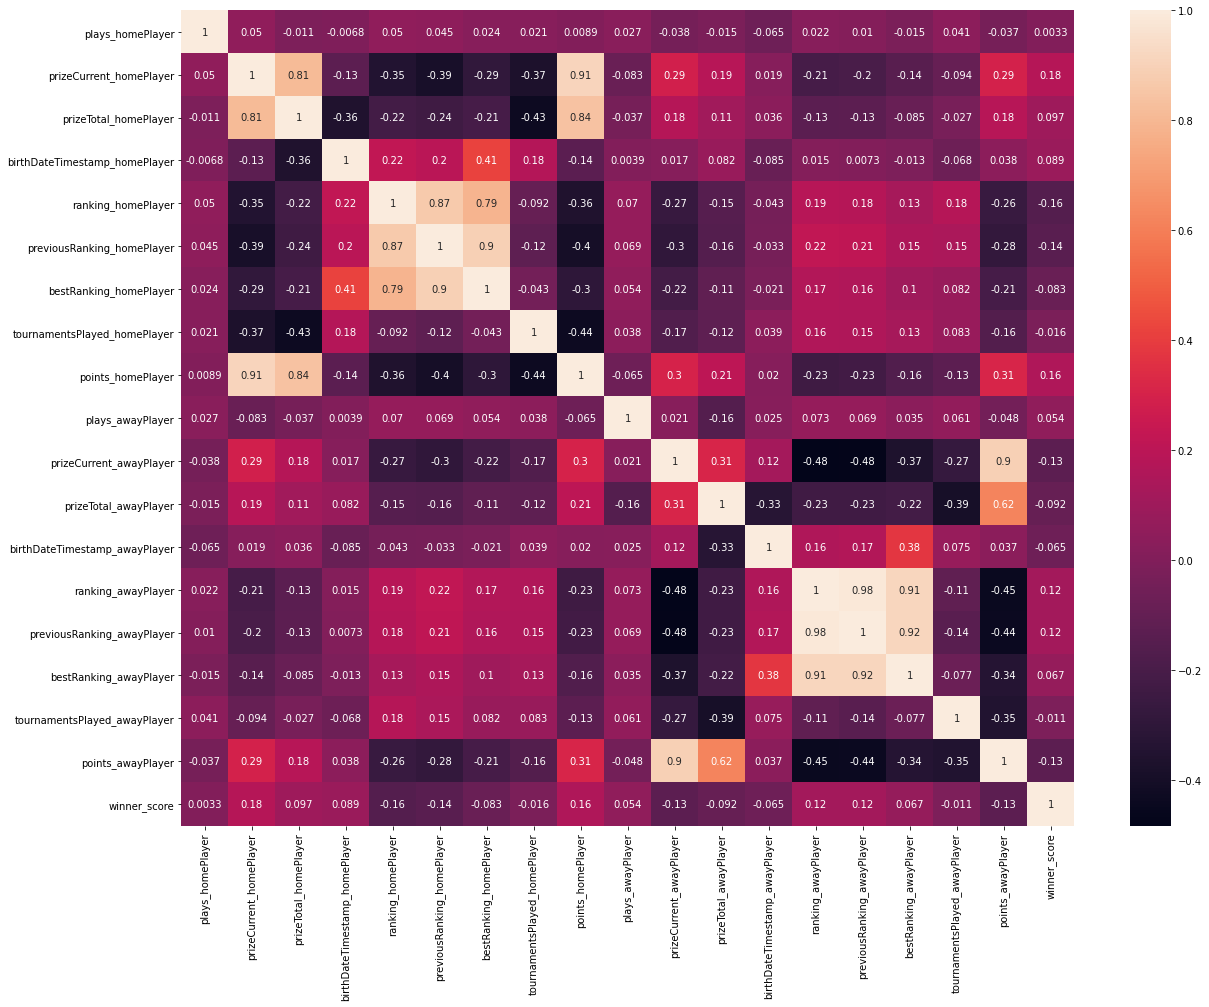

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(20,15))
sns.heatmap(df_events.corr(), annot=True, ax=ax)

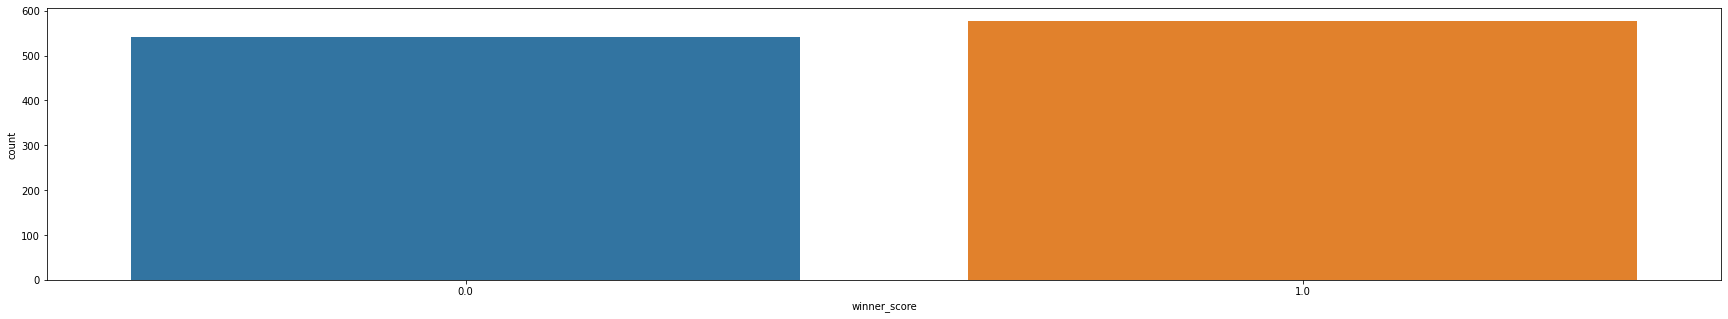

In [111]:
sns.countplot(x=df_events.winner_score)

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
import numpy as np

X = df_events.iloc[:,:-1]
y = df_events.iloc[ :, -1:]

size_input_data = len(X.columns)

y = np.reshape(y, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(X))
x_scale = scaler_x.transform(X)
print(scaler_y.fit(y))
y_scale = scaler_y.transform(y)

# Separamos en conjunto de entrenamiento y conjunto de test
X_train, X_test, y_train, y_test = train_test_split(x_scale, y_scale)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


## Entrenamiento de la red neuronal

Antes de nada, separamos entre las variables predictoras y la variable 'target'

In [113]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

from keras import models, layers, losses, optimizers, metrics

model = Sequential()

model.add(Dense(size_input_data, input_dim=size_input_data))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# model.add(Dense(1000))
# model.add(Activation('relu'))
# model.add(Dropout(0.4))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation('linear'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 24)                600       
_________________________________________________________________
batch_normalization_28 (Batc (None, 24)                96        
_________________________________________________________________
activation_28 (Activation)   (None, 24)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1000)              25000     
_________________________________________________________________
batch_normalization_29 (Batc (None, 1000)              4000      
_________________________________________________________________
activation_29 (Activation)   (None, 1000)             

In [114]:
import tensorflow as tf

# Configuramos el learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)


# Compilamos el modelo
model.compile(loss=loss, optimizer=optimizer, metrics=['mse','mae'])

In [115]:
# Entrenamos la red neuronal
history = model.fit(X_train, y_train, epochs=120, batch_size=40, verbose=1, validation_split=0.2)

Epoch 1/120
17/17 [==============================] - 3s 48ms/step - loss: 1.4106 - mse: 1.4106 - mae: 0.9317 - val_loss: 0.6313 - val_mse: 0.6313 - val_mae: 0.6296
Epoch 2/120
17/17 [==============================] - 0s 10ms/step - loss: 1.2196 - mse: 1.2196 - mae: 0.8446 - val_loss: 0.5912 - val_mse: 0.5912 - val_mae: 0.6038
Epoch 3/120
17/17 [==============================] - 0s 10ms/step - loss: 1.2762 - mse: 1.2762 - mae: 0.8775 - val_loss: 0.5825 - val_mse: 0.5825 - val_mae: 0.5987
Epoch 4/120
17/17 [==============================] - 0s 9ms/step - loss: 1.0822 - mse: 1.0822 - mae: 0.8076 - val_loss: 0.5774 - val_mse: 0.5774 - val_mae: 0.5951
Epoch 5/120
17/17 [==============================] - 0s 10ms/step - loss: 1.0386 - mse: 1.0386 - mae: 0.8076 - val_loss: 0.5682 - val_mse: 0.5682 - val_mae: 0.5882
Epoch 6/120
17/17 [==============================] - 0s 9ms/step - loss: 0.9751 - mse: 0.9751 - mae: 0.7701 - val_loss: 0.5175 - val_mse: 0.5175 - val_mae: 0.5534
Epoch 7/120
17/17 

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


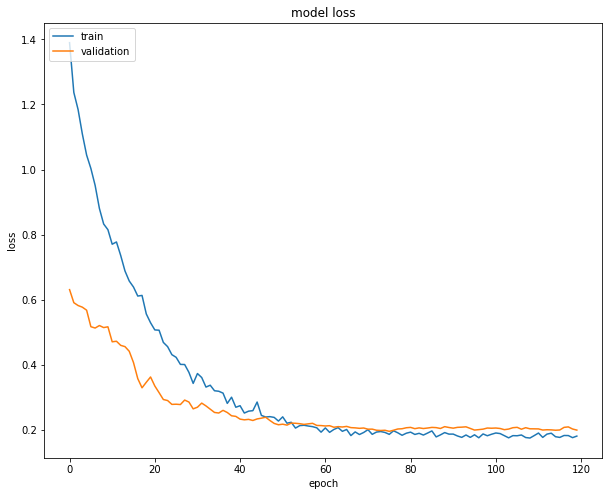

27/27 [==============================] - 0s 2ms/step - loss: 0.1622 - mse: 0.1622 - mae: 0.3543
mse: 16.22%


In [116]:
print(history.history.keys())
# "Loss"
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

scores = model.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

<Figure size 2160x360 with 0 Axes>

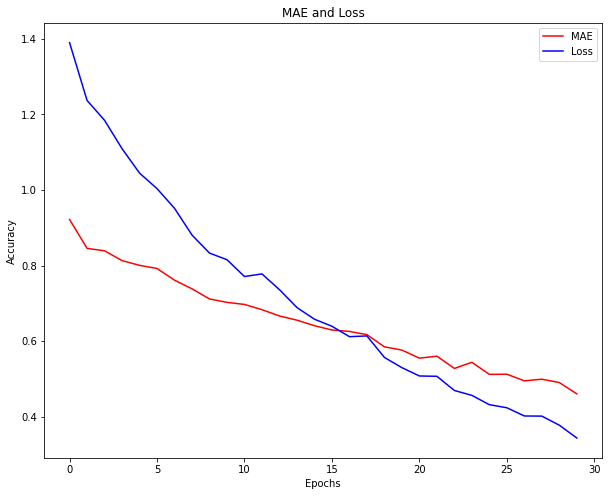

<Figure size 2160x360 with 0 Axes>

In [117]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch con zoom
#------------------------------------------------
#-----------------------------------------------------------
# Recuperar una lista de resultados de la lista de datos de entrenamiento y pruebas para cada epoch de entrenamiento
#-----------------------------------------------------------
loss=history.history['loss']
mae=history.history['mae']
epochs=range(len(loss)) # Get number of epochs

zoomed_loss = loss[0:30]
zoomed_mae = mae[0:30]
zoomed_epochs = range(0,30)
#
## tu código para el plot con zoom del ejercicio 8 aquí
plt.figure(figsize=(10,8))
plt.plot(zoomed_epochs, zoomed_mae, 'r')
plt.plot(zoomed_epochs, zoomed_loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [118]:
def plot_prediction(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Tu código del clasificador de la pregunta 3 aquí ###
predictions = model.predict(X_test)

i = 6
print(y_test[i])
print(predictions[i])

[0.]
[0.0758248]


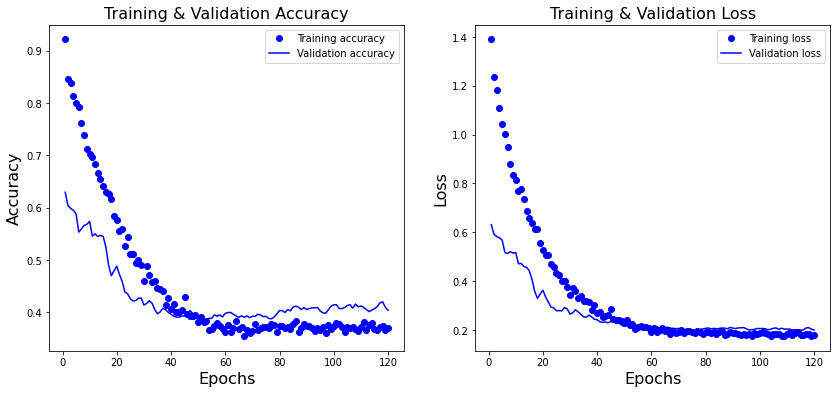

In [119]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['mae']
val_accuracy = history_dict['val_mae']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy (MAE) vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

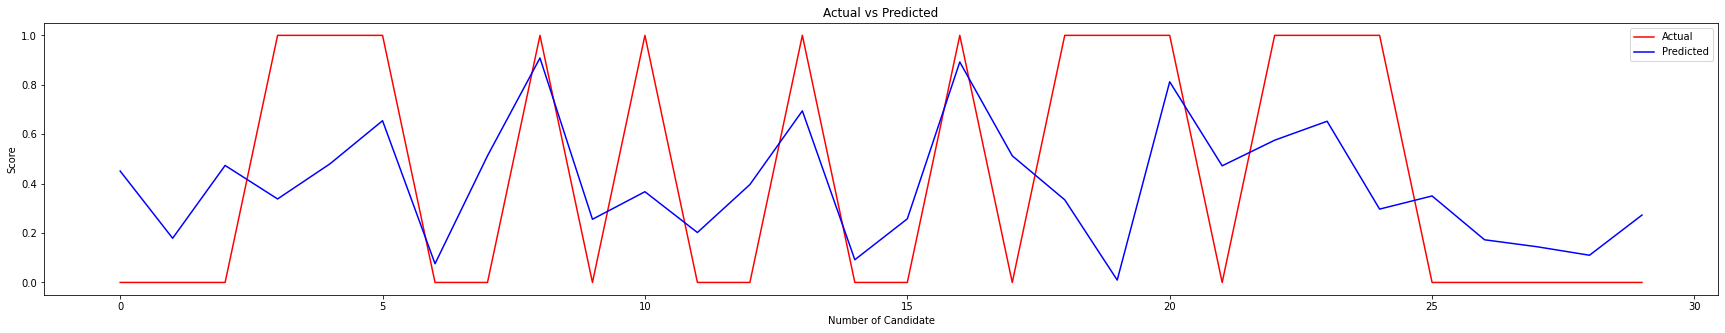

In [120]:
y_pred= model.predict(X_test)
#invert normalize
y_pred = scaler_y.inverse_transform(y_pred) 

#Visualising the Acutal and predicted Result
plt.rcParams["figure.figsize"] = (30,5)
plt.plot(y_test[:30], color = 'red', label = 'Actual')
plt.plot(y_pred[:30], color = 'blue', label = 'Predicted')
plt.xlabel('Number of Candidate')
plt.ylabel('Score')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()